In [3]:

import json
import zipfile
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [4]:
import os
print(os.listdir())


['.ipynb_checkpoints', 'Readme.txt', 'score_distribution_plot.png', 'Untitled.ipynb', 'user-wallet-transactions.json.zip', 'wallet_credit_score.ipynb', 'wallet_scores.json', 'wallet_scores_classified.csv']


In [5]:
from collections import defaultdict
import json
import zipfile

# Scoring weights
WEIGHT_DEPOSIT = 0.1
WEIGHT_REPAY_RATIO = 300
PENALTY_LIQUIDATION = 100
BASE_SCORE = 500


In [6]:
import zipfile
import json

zip_path = 'user-wallet-transactions.json.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    file_name = zip_ref.namelist()[0]
    with zip_ref.open(file_name) as f:
        data = json.load(f)


data[:2]


[{'_id': {'$oid': '681d38fed63812d4655f571a'},
  'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6',
  'network': 'polygon',
  'protocol': 'aave_v2',
  'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190',
  'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit',
  'timestamp': 1629178166,
  'blockNumber': 1629178166,
  'action': 'deposit',
  'actionData': {'type': 'Deposit',
   'amount': '2000000000',
   'assetSymbol': 'USDC',
   'assetPriceUSD': '0.9938318274296357543568636362026045',
   'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174',
   'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'},
  '__v': 0,
  'createdAt': {'$date': '2025-05-08T23:06:39.465Z'},
  'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}},
 {'_id': {'$oid': '681aa70dd6df53021cc6f3c0'},
  'userWallet': '0x000000000051d07a4fb3bd10121a343d85818da6',
  'network': 'polygon',
  'protocol': 'aave_v2',
  'txHash': '0xe6fc162c86b2928b0ba9b82bda6727

In [7]:
def load_transactions(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        json_file = [f for f in zip_ref.namelist() if f.endswith('.json')][0]
        with zip_ref.open(json_file) as f:
            data = json.load(f)
    return data


def compute_features(data):
    wallets = defaultdict(lambda: defaultdict(float))
    for tx in data:
        wallet = tx['userWallet']
        action = tx['action'].lower()
        amount = float(tx.get('actionData', {}).get('amount', 0))

        if action in ['deposit', 'borrow', 'repay', 'redeemunderlying', 'liquidationcall']:
            wallets[wallet][action] += amount
            wallets[wallet]['total_txns'] += 1

    return wallets


def compute_scores(wallet_features):
    scores = {}
    for wallet, feats in wallet_features.items():
        deposit = feats.get('deposit', 0)
        borrow = feats.get('borrow', 0)
        repay = feats.get('repay', 0)
        liquidate = feats.get('liquidationcall', 0)
        txns = feats.get('total_txns', 1)

        score = 600 + 0.000001 * deposit - 0.000002 * borrow + 0.000002 * repay - 0.000005 * liquidate
        score += 10 * (repay / txns)
        score = max(0, min(1000, int(score)))
        scores[wallet] = score
    return scores


def classify_risk(score):
    if score >= 750:
        return 'Safe'
    elif score >= 500:
        return 'Moderate'
    else:
        return 'Risky'


def save_results(scores, output_json='wallet_scores.json', output_csv='wallet_scores_classified.csv'):
    with open(output_json, 'w') as f:
        json.dump(scores, f, indent=2)

    df = pd.DataFrame(list(scores.items()), columns=['Wallet', 'Score'])
    df['Risk'] = df['Score'].apply(classify_risk)
    df.to_csv(output_csv, index=False)
    print(f"RESULTS SAVED TO {output_json} and {output_csv}")


def plot_histogram(scores):
    plt.hist(scores.values(), bins=20, edgecolor='black')
    plt.title("Wallet Credit Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Number of Wallets")
    plt.grid(True)
    plt.show()


Total transactions parsed: 100000
Total unique wallets: 3497
RESULTS SAVED TO wallet_scores.json and wallet_scores_classified.csv


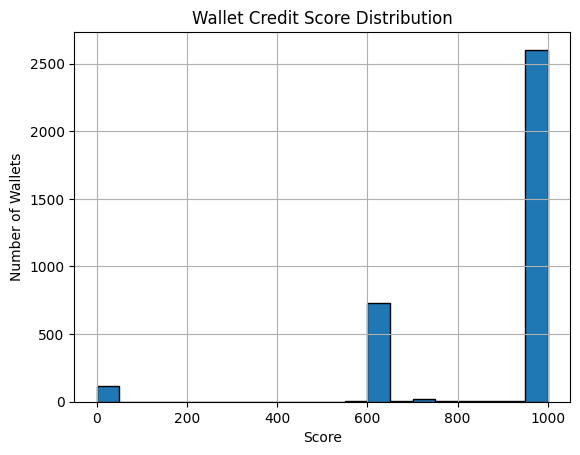


 Sample Wallet Scores:
0x00000000001accfa9cef68cf5371a23025b6d4b6: 1000
0x000000000051d07a4fb3bd10121a343d85818da6: 1000
0x000000000096026fb41fc39f9875d164bd82e2dc: 1000
0x0000000000e189dd664b9ab08a33c4839953852c: 600
0x0000000002032370b971dabd36d72f3e5a7bf1ee: 1000
0x000000000a38444e0a6e37d3b630d7e855a7cb13: 1000
0x000000003853fcedcd0355fec98ca3192833f00b: 1000
0x000000003ce0cf2c037493b1dc087204bd7f713e: 1000
0x000000007858e6f2668e1e06111cfa24403a5466: 1000
0x00000001a0f57e850c9db68b4a9bc34677437c5c: 601


In [8]:

zip_path = 'user-wallet-transactions.json.zip'

data = load_transactions(zip_path)
print(f"Total transactions parsed: {len(data)}")

wallet_features = compute_features(data)
print(f"Total unique wallets: {len(wallet_features)}")

scores = compute_scores(wallet_features)

save_results(scores)

plot_histogram(scores)


print("\n Sample Wallet Scores:")
for wallet in list(scores.keys())[:10]:
    print(f"{wallet}: {scores[wallet]}")


In [9]:
def load_transactions(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        json_name = zip_ref.namelist()[0]
        with zip_ref.open(json_name) as f:
            data = json.load(f)
    return data


In [10]:
def compute_features(data):
    wallets = defaultdict(lambda: defaultdict(float))
    for tx in data:
        wallet = tx['userWallet']
        action = tx['action'].lower()
        
        amount_str = tx.get('actionData', {}).get('amount', '0')
        try:
            amount = float(amount_str)
        except ValueError:
            amount = 0

        if action == 'deposit':
            wallets[wallet]['total_deposit'] += amount
            wallets[wallet]['num_deposit'] += 1

        elif action == 'borrow':
            wallets[wallet]['total_borrow'] += amount
            wallets[wallet]['num_borrow'] += 1

        elif action == 'repay':
            wallets[wallet]['total_repay'] += amount
            wallets[wallet]['num_repay'] += 1

        elif action == 'liquidationcall':
            wallets[wallet]['num_liquidation'] += 1
    return wallets


In [11]:
def compute_scores(wallet_features):
    scores = {}
    for wallet, feats in wallet_features.items():
        deposit = feats['total_deposit']
        repay_ratio = feats['num_repay'] / feats['num_borrow'] if feats['num_borrow'] else 0
        liquidations = feats['num_liquidation']

        score = BASE_SCORE
        score += WEIGHT_DEPOSIT * deposit
        score += WEIGHT_REPAY_RATIO * repay_ratio
        score -= PENALTY_LIQUIDATION * liquidations

        scores[wallet] = max(0, min(1000, round(score)))
    return scores


In [12]:
print(data[0])


{'_id': {'$oid': '681d38fed63812d4655f571a'}, 'userWallet': '0x00000000001accfa9cef68cf5371a23025b6d4b6', 'network': 'polygon', 'protocol': 'aave_v2', 'txHash': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190', 'logId': '0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6d2e66e6b0e3b2e8d4190_Deposit', 'timestamp': 1629178166, 'blockNumber': 1629178166, 'action': 'deposit', 'actionData': {'type': 'Deposit', 'amount': '2000000000', 'assetSymbol': 'USDC', 'assetPriceUSD': '0.9938318274296357543568636362026045', 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174', 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}, '__v': 0, 'createdAt': {'$date': '2025-05-08T23:06:39.465Z'}, 'updatedAt': {'$date': '2025-05-08T23:06:39.465Z'}}


In [13]:
import json
with open('wallet_scores.json') as f:
    results = json.load(f)
print(len(results), "wallets scored.")


3497 wallets scored.


In [14]:
with open('wallet_scores.json') as f:
    results = json.load(f)

print(f" Total wallets scored: {len(results)}")


 Total wallets scored: 3497


In [15]:
def classify_wallet(score):
    if score >= 800:
        return 'Safe'
    elif score >= 500:
        return 'Moderate'
    else:
        return 'Risky'


In [16]:
import csv

with open('wallet_scores_classified.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['wallet', 'score', 'risk_level'])
    for wallet, score in results.items():
        label = classify_wallet(score)
        writer.writerow([wallet, score, label])

print(" Exported with classifications to wallet_scores_classified.csv")


 Exported with classifications to wallet_scores_classified.csv


In [17]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
print(f"Total transactions parsed: {len(data)}")
print(f"Total unique wallets: {len(wallet_features)}")


Total transactions parsed: 100000
Total unique wallets: 3497


In [24]:
import pandas as pd

df = pd.read_csv("wallet_scores_classified.csv")
print(df.columns.tolist())






['wallet', 'score', 'risk_level']


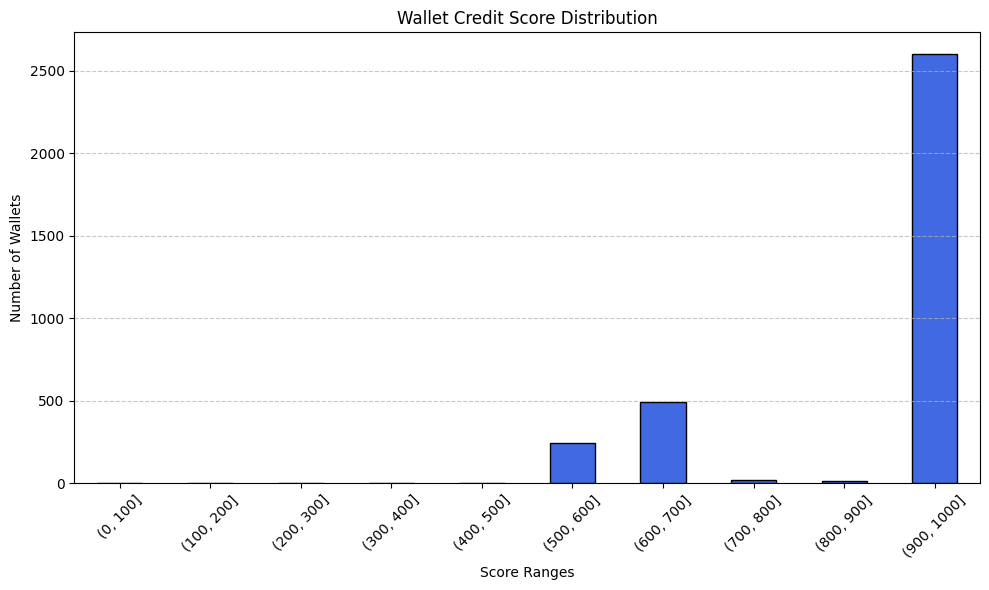

In [26]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("wallet_scores_classified.csv")


df['Bucket'] = pd.cut(df['score'], bins=[0,100,200,300,400,500,600,700,800,900,1000])

bucket_counts = df['Bucket'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bucket_counts.plot(kind='bar', color='royalblue', edgecolor='black')
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score Ranges")
plt.ylabel("Number of Wallets")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()
